INSTALLS

In [ ]:
!pip install ijson
!pip install shap
!pip install pdpbox

IMPORTS

In [ ]:
import pandas as pd
import os
from tqdm import tqdm
import ijson
from sklearn.feature_extraction.text import TfidfVectorizer
import shap
from pdpbox import pdp
import joblib
import json
import gzip
import pdpbox
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import ndcg_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from google.colab import drive
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import PowerTransformer
import nltk
import ast
from nltk.corpus import stopwords
drive.mount("/content/drive", force_remount=True)

ads_non_duplicate_path = '/content/drive/MyDrive/Bitirme/ads_non_duplicate.json'
ads_dataframe_age_filtered = '/content/drive/MyDrive/Bitirme/ads_dataframe.csv'


Mounted at /content/drive


# **AGE-GENDER-WORDS FILTERING**

JSON TO CSV CONVERSION (AGE-GENDER FILTERING)

In [ ]:
with open(ads_non_duplicate_path, 'r') as file:
    data = json.load(file)

processed_data = []

for item in data:

    selected_attributes = {
        'ad_creation_time': item.get('ad_creation_time'),
        'ad_creative_bodies': item.get('ad_creative_bodies'),
        'currency': item.get('currency'),
        'impressions': item.get('impressions'),
        'spend': item.get('spend'),
        'delivery_by_region': item.get('delivery_by_region', []),
        'demographic_distribution': item.get('demographic_distribution', [])
    }
    processed_data.append(selected_attributes)

df_age_filtered = pd.DataFrame(processed_data)

df_age_filtered.to_csv(ads_dataframe_age_filtered, index=False)

LOAD DATAFRAME (AGE-GENDER FILTERING) & GET INFORMATION

In [ ]:
df_age_filtered = pd.read_csv(ads_dataframe_age_filtered)
print(df_age_filtered.dtypes)
df_age_filtered.head()

ad_creation_time            object
ad_creative_bodies          object
currency                    object
impressions                 object
spend                       object
delivery_by_region          object
demographic_distribution    object
dtype: object


,ad_creation_time,ad_creative_bodies,currency,impressions,spend,delivery_by_region,demographic_distribution
0,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '10000', 'upper_bound': '14999'}","{'lower_bound': '300', 'upper_bound': '399'}","[{'percentage': '0.002039', 'region': 'Hawaii'...","[{'percentage': '0.000213', 'age': '18-24', 'g..."
1,2021-12-07,['We need to call out all discrimination – whe...,USD,"{'lower_bound': '4000', 'upper_bound': '4999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.0003', 'region': 'Wyoming'}...","[{'percentage': '0.001782', 'age': '45-54', 'g..."
2,2021-12-07,['Too many on the right seem only concerned ab...,USD,"{'lower_bound': '2000', 'upper_bound': '2999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.002145', 'region': 'Alaska'...","[{'percentage': '0.000423', 'age': '45-54', 'g..."
3,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.002674', 'region': 'Delawar...","[{'percentage': '0.016002', 'age': '25-34', 'g..."
4,2021-12-07,"[""Too many on the right seem only concerned ab...",USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.009534', 'region': 'Alabama...","[{'percentage': '0.000757', 'age': '35-44', 'g..."


CONVERT INTO DATAFRAME (AGE-GENDER FILTERING)


In [ ]:
new_df_age_filtered = pd.DataFrame()

# Convert 'ad_creation_time' to datetime
new_df_age_filtered['ad_creation_time'] = pd.to_datetime(df_age_filtered['ad_creation_time'])

# Extract 'ad_creative_bodies'
new_df_age_filtered['ad_creative_bodies'] = df_age_filtered['ad_creative_bodies'].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else x).astype(str)

# Extract 'lower_bound' and 'upper_bound' values for impressions and spend
new_df_age_filtered['impressions_lower'] = df_age_filtered['impressions'].apply(lambda x: ast.literal_eval(x).get('lower_bound', None)).astype("float")
new_df_age_filtered['impressions_upper'] = df_age_filtered['impressions'].apply(lambda x: ast.literal_eval(x).get('upper_bound', None)).astype("float")
new_df_age_filtered['spend_lower'] = df_age_filtered['spend'].apply(lambda x: ast.literal_eval(x).get('lower_bound', None)).astype("float")
new_df_age_filtered['spend_upper'] = df_age_filtered['spend'].apply(lambda x: ast.literal_eval(x).get('upper_bound', None)).astype("float")

# Create columns for unique region names
'''
unique_regions = set()
for item in df['delivery_by_region']:
    try:
        regions = ast.literal_eval(item)
        for region in regions:
            if 'region' in region:
                unique_regions.add(region['region'])
    except (SyntaxError, ValueError):
        pass

for region in unique_regions:
    new_df_age_filtered[f'percentage_{region}'] = None
'''
# Create columns for age intervals
unique_age_intervals = set()
for item in df_age_filtered['demographic_distribution']:
    try:
        demographics = ast.literal_eval(item)
        for demographic in demographics:
            age = demographic.get('age', None)
            gender = demographic.get('gender', None)
            if age is not None and gender is not None:
                age_gender_key = f'{age}_{gender}'
                unique_age_intervals.add(age_gender_key)
    except (SyntaxError, ValueError):
        pass

for age_interval in unique_age_intervals:
    new_df_age_filtered[f'percentage_{age_interval}'] = None
'''
# Iterate through the data to fill in information or use percentages as empty
for i, item in enumerate(df['delivery_by_region']):
    try:
        regions = ast.literal_eval(item)
        for region in regions:
            if 'region' in region:
                new_df_age_filtered.at[i, f'percentage_{region["region"]}'] = region.get('percentage', None)
    except (SyntaxError, ValueError):
        pass
'''
for i, item in enumerate(df_age_filtered['demographic_distribution']):
    try:
        demographics = ast.literal_eval(item)
        for demographic in demographics:
            age = demographic.get('age', None)
            gender = demographic.get('gender', None)
            if age is not None and gender is not None:
                age_gender_key = f'{age}_{gender}'
                new_df_age_filtered.at[i, f'percentage_{age_gender_key}'] = demographic.get('percentage', None)
    except (SyntaxError, ValueError):
        pass

# Display data types and the head of the new DataFrame
print(new_df_age_filtered.dtypes)
new_df_age_filtered.head()

ad_creation_time              datetime64[ns]
ad_creative_bodies                    object
impressions_lower                    float64
impressions_upper                    float64
spend_lower                          float64
spend_upper                          float64
percentage_Unknown_unknown            object
percentage_25-34_unknown              object
percentage_35-44_male                 object
percentage_18-24_female               object
percentage_13-17_male                 object
percentage_45-54_female               object
percentage_35-44_female               object
percentage_65+_unknown                object
percentage_55-64_male                 object
percentage_65+_male                   object
percentage_18-24_unknown              object
percentage_45-54_unknown              object
percentage_25-34_male                 object
percentage_35-44_unknown              object
percentage_18-24_male                 object
percentage_25-34_female               object
percentage

,ad_creation_time,ad_creative_bodies,impressions_lower,impressions_upper,spend_lower,spend_upper,percentage_Unknown_unknown,percentage_25-34_unknown,percentage_35-44_male,percentage_18-24_female,...,percentage_25-34_male,percentage_35-44_unknown,percentage_18-24_male,percentage_25-34_female,percentage_55-64_unknown,percentage_13-17_female,percentage_55-64_female,percentage_13-17_unknown,percentage_65+_female,percentage_45-54_male
0,2021-12-07,As the quotation on the wall of the Holocaust ...,10000.0,14999.0,300.0,399.0,None,0.001382,0.188836,0.002339,...,0.173418,0.003615,0.029452,0.029027,0.001595,None,0.07932,None,0.064646,0.142584
1,2021-12-07,We need to call out all discrimination – where...,4000.0,4999.0,100.0,199.0,None,0.001485,0.06237,0.00297,...,0.041283,0.000891,0.012177,0.019305,0.001188,None,0.166023,None,0.183546,0.102762
2,2021-12-07,Too many on the right seem only concerned abou...,2000.0,2999.0,100.0,199.0,None,0.002537,0.07907,0.013531,...,0.121353,0.003383,0.054123,0.059197,0.001691,None,0.129387,None,0.109514,0.07907
3,2021-12-07,As the quotation on the wall of the Holocaust ...,15000.0,19999.0,100.0,199.0,None,0.000678,0.112558,0.003119,...,0.07757,0.00217,0.014375,0.016002,0.002441,None,0.123678,None,0.15853,0.125576
4,2021-12-07,Too many on the right seem only concerned abou...,15000.0,19999.0,100.0,199.0,None,0.000973,0.04195,0.002703,...,0.032003,0.000757,0.007785,0.013299,0.002162,None,0.1265,None,0.334306,0.061953


MERGE COLUMNS AND SORT ACCORDING TO DATE (AGE-GENDER FILTERING)

In [ ]:
ads_dataframe_age_filtered = new_df_age_filtered.copy(deep=True)
ads_dataframe_age_filtered['cpi'] = (
    (new_df_age_filtered['spend_lower'].fillna(new_df_age_filtered['spend_upper']) / 2 +
     new_df_age_filtered['spend_upper'].fillna(new_df_age_filtered['spend_lower']) / 2) /
    (new_df_age_filtered['impressions_lower'].fillna(new_df_age_filtered['impressions_upper']) / 2 +
     new_df_age_filtered['impressions_upper'].fillna(new_df_age_filtered['impressions_lower']) / 2)
)
print(type(ads_dataframe_age_filtered))
ads_dataframe_age_filtered = ads_dataframe_age_filtered.drop(columns=['impressions_lower', 'impressions_upper', 'spend_lower', 'spend_upper'])
ads_dataframe_age_filtered = ads_dataframe_age_filtered.sort_values(by='ad_creation_time')

ads_dataframe_age_filtered

<class 'pandas.core.frame.DataFrame'>


,ad_creation_time,ad_creative_bodies,percentage_Unknown_unknown,percentage_25-34_unknown,percentage_35-44_male,percentage_18-24_female,percentage_13-17_male,percentage_45-54_female,percentage_35-44_female,percentage_65+_unknown,...,percentage_35-44_unknown,percentage_18-24_male,percentage_25-34_female,percentage_55-64_unknown,percentage_13-17_female,percentage_55-64_female,percentage_13-17_unknown,percentage_65+_female,percentage_45-54_male,cpi
5910,2014-06-12,ActiveGuard® is the first mattress liner to ac...,None,0.000502,0.079054,0.019368,None,0.153441,0.172859,0.000176,...,0.000778,0.011164,0.104819,0.000502,None,0.150681,None,0.101909,0.064402,0.042218
14593,2014-07-17,"Mark Segal, PGN publisher, is the nation’s mos...",None,0.001579,0.025031,0.147254,0.059082,0.018942,0.012854,0.001353,...,None,0.073514,0.027512,0.000677,0.153118,0.061337,0.003157,0.144548,0.047807,0.006915
18282,2015-02-20,"Architecture, Engineering, Construction. \nInt...",None,0.001146,0.079762,0.011918,None,0.060738,0.030254,0.001834,...,0.001834,0.0314,0.03438,0.001834,None,0.097181,None,0.181985,0.109787,0.068372
24367,2015-04-16,Conservative Political Commentary & Humor!,None,0.00072,0.212005,0.002881,0.001441,0.029532,0.02497,0.00048,...,0.002401,0.026891,0.014406,0.001441,0.00024,0.034574,None,0.015606,0.254022,0.005253
25900,2015-06-15,First step in finding the right Dentist? Resea...,None,None,None,None,None,0.286791,0.076813,None,...,None,None,None,None,None,0.302943,None,0.333453,None,0.011089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93977,2021-12-28,It was one of the best nights of my career. No...,None,None,0.006135,None,None,0.01227,None,0.006135,...,None,None,0.018405,0.006135,None,0.08589,None,0.509202,0.018405,0.099099
106359,2021-12-28,Follow four young people in Tucson as they lea...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0.099099
66492,2021-12-28,DEVELOPING... the most significant environment...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0.099099
68581,2021-12-28,The right education can make all the differenc...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0.099099


SAMPLE AGE-GENDER FILTERING DATASET SEPERATION

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:

# Create gender_data_train and gender_data_test DataFrames
gender_data_train = train_data[selected_columns]
gender_data_test = test_data[selected_columns]

# Text preprocessing
def preprocess_text(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', str(text).lower())

gender_data_train['ad_creative_bodies'] = gender_data_train['ad_creative_bodies'].apply(preprocess_text)
gender_data_test['ad_creative_bodies'] = gender_data_test['ad_creative_bodies'].apply(preprocess_text)

# Separate features and target variable for training and testing sets
X_train = gender_data_train.drop('cpi', axis=1)
y_train = gender_data_train['cpi']
X_test = gender_data_test.drop('cpi', axis=1)
y_test = gender_data_test['cpi']
# Define stop words
stop_words = set(stopwords.words('english'))
stop_words_list = list(stop_words)  # Convert set to list
# Define a ColumnTransformer
# Define a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(max_features=100, stop_words=stop_words_list), 'ad_creative_bodies'),
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('passthrough', 'passthrough')
        ]), [col for col in selected_columns if col != 'ad_creative_bodies' and col != 'cpi'])
    ],
    remainder='passthrough'
)

# Create a pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])



TRAINING THE MODEL

In [84]:
# Train the model
model.fit(X_train, y_train)

# Transform both X_train and X_test using the preprocessor
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert both to dense arrays and ensure the data type is float64
X_train_dense = X_train_transformed.toarray().astype(np.float64) if not isinstance(X_train_transformed, np.ndarray) else X_train_transformed.astype(np.float64)
X_test_dense = X_test_transformed.toarray().astype(np.float64) if not isinstance(X_test_transformed, np.ndarray) else X_test_transformed.astype(np.float64)

# Create a SHAP explainer using th

#Interpreting The Model

 99%|===================| 39576/39911 [00:47<00:00]       

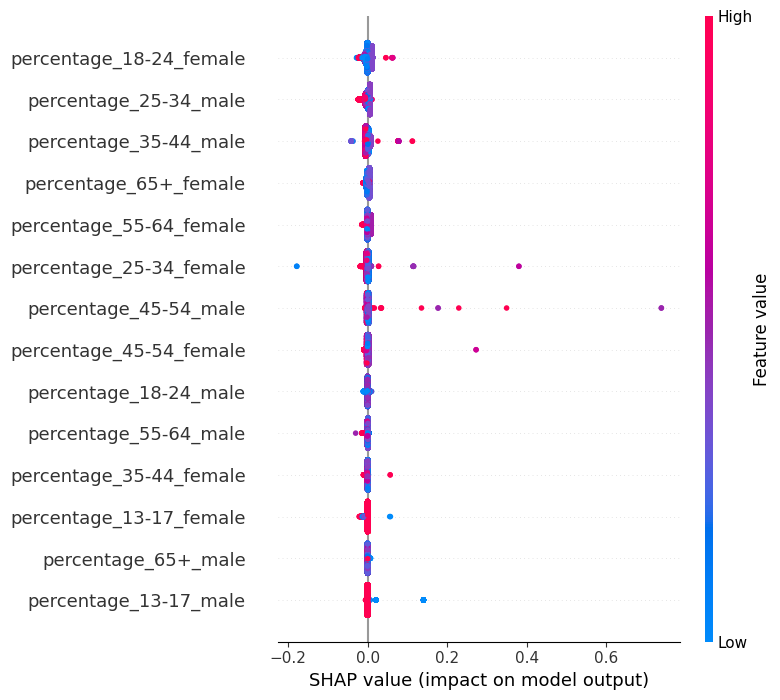

In [85]:

# Define the selected columns
selected_percentage_columns = [

    'percentage_25-34_male',
    'percentage_25-34_female',
    'percentage_35-44_male',
    'percentage_13-17_male',
    'percentage_55-64_male',
    'percentage_18-24_male',
    'percentage_65+_male',
    'percentage_35-44_female',
    'percentage_13-17_female',
    'percentage_55-64_female',
    'percentage_18-24_female',
    'percentage_65+_female',
    'percentage_45-54_male',
    'percentage_45-54_female'
]

# Use the full dataset for SHAP analysis
full_explainer = shap.Explainer(model.named_steps['model'], X_train_dense)
full_shap_values = full_explainer.shap_values(X_test_dense)

# Focus on the age and gender features in the summary plot
# Assume the first N features are text features, and the rest are numeric
N = len(preprocessor.named_transformers_['text'].get_feature_names_out())
numeric_features_shap_values = full_shap_values[:, N:]

shap.summary_plot(numeric_features_shap_values, X_test_dense[:, N:], feature_names=selected_percentage_columns)

#LOOKING INTO THE TEST INSTANCE OF 166 INDEX

<Figure size 640x480 with 0 Axes>

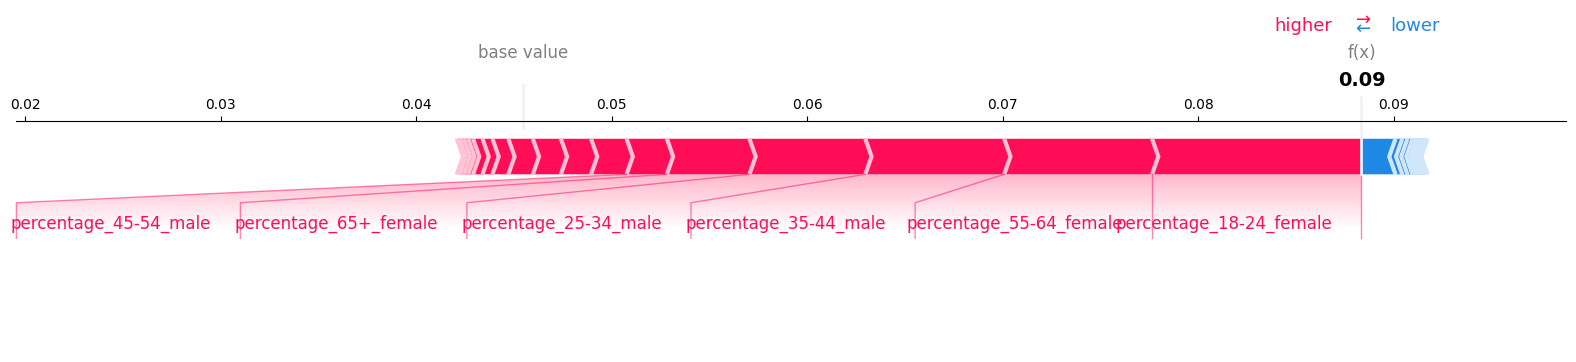

In [86]:
import matplotlib.pyplot as plt
import shap

# Select a single instance from the test set
instance_index = 166  # Adjust this index as needed
single_instance = X_test.iloc[instance_index:instance_index+1]

# Preprocess the single instance
single_instance_transformed = preprocessor.transform(single_instance)

# Convert to dense array if necessary
single_instance_dense = single_instance_transformed.toarray().astype(np.float64) if not isinstance(single_instance_transformed, np.ndarray) else single_instance_transformed.astype(np.float64)

# Create an explainer using the trained model
explainer = shap.Explainer(model.named_steps['model'], X_train_dense)

# Calculate SHAP values for the single instance
shap_values_single = explainer.shap_values(single_instance_dense)

# Extract the SHAP values for the instance
shap_values_instance = shap_values_single[0] if isinstance(shap_values_single, list) else shap_values_single

# Prepare feature names corresponding to the transformed features
# Get the feature names from the 'text' transformer
feature_names_text = preprocessor.named_transformers_['text'].get_feature_names_out()
# Combine the text feature names with other numeric feature names
all_feature_names = list(feature_names_text) + selected_percentage_columns

# Ensure the feature names align with the SHAP values dimensions
assert len(all_feature_names) == shap_values_instance.shape[1], "Feature names and SHAP values dimension mismatch"

# Generate the SHAP force plot using matplotlib
shap.initjs()
plt.figure()
shap.force_plot(explainer.expected_value, shap_values_instance[0], feature_names=all_feature_names, matplotlib=True)
plt.show()


                                      ad_creative_bodies  \
50123  serious update trump blocked democrats plan to...   

      percentage_25-34_male percentage_25-34_female percentage_35-44_male  \
50123                  None                    None                  None   

      percentage_13-17_male percentage_55-64_male percentage_18-24_male  \
50123                  None                  None                  None   

      percentage_65+_male percentage_35-44_female percentage_13-17_female  \
50123                None                    None                    None   

      percentage_55-64_female percentage_18-24_female percentage_65+_female  \
50123                    None                    None                  None   

      percentage_45-54_male percentage_45-54_female  
50123                  None                    None  


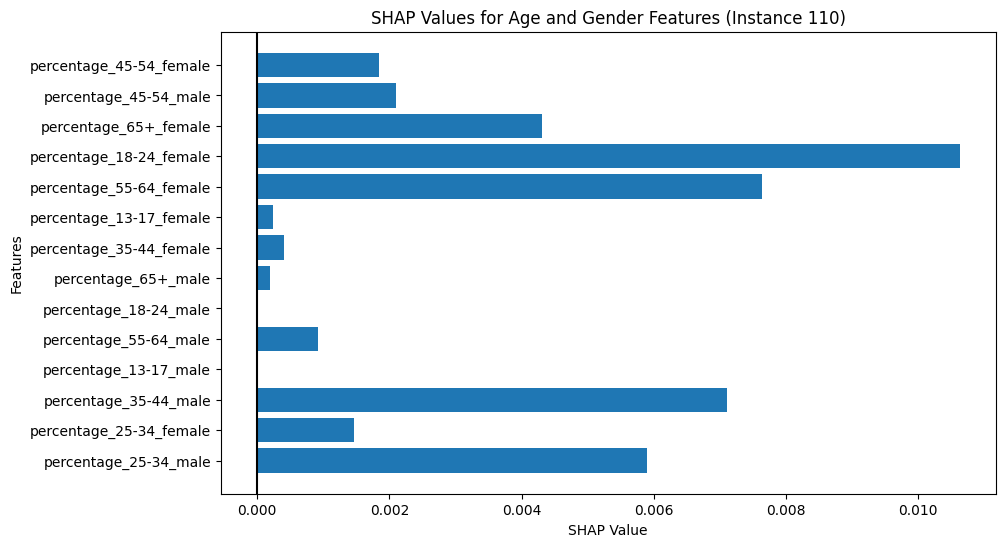

In [165]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# Select a single instance from the test set
instance_index = 110  # Adjust this index as needed
single_instance = X_test.iloc[instance_index:instance_index+1]
instance_templete = single_instance
print(single_instance)
# Preprocess the single instance
single_instance_transformed = preprocessor.transform(single_instance)

# Convert to dense array if necessary
single_instance_dense = single_instance_transformed.toarray().astype(np.float64) if not isinstance(single_instance_transformed, np.ndarray) else single_instance_transformed.astype(np.float64)

# Create an explainer using the trained model
explainer = shap.Explainer(model.named_steps['model'], X_train_dense)

# Calculate SHAP values for the single instance
shap_values_single = explainer.shap_values(single_instance_dense)

# Extract the SHAP values for the instance
shap_values_instance = shap_values_single[0] if isinstance(shap_values_single, list) else shap_values_single

# Focus only on numeric features (age and gender)
numeric_shap_values_instance = shap_values_instance[:, len(feature_names_text):]

# Corresponding numeric feature names
numeric_feature_names = selected_percentage_columns

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(numeric_feature_names, numeric_shap_values_instance[0])
plt.xlabel('SHAP Value')
plt.ylabel('Features')
plt.title('SHAP Values for Age and Gender Features (Instance {})'.format(instance_index))
plt.axvline(x=0, color='k')
plt.show()


SHAP VALUE FOR THE WORDS

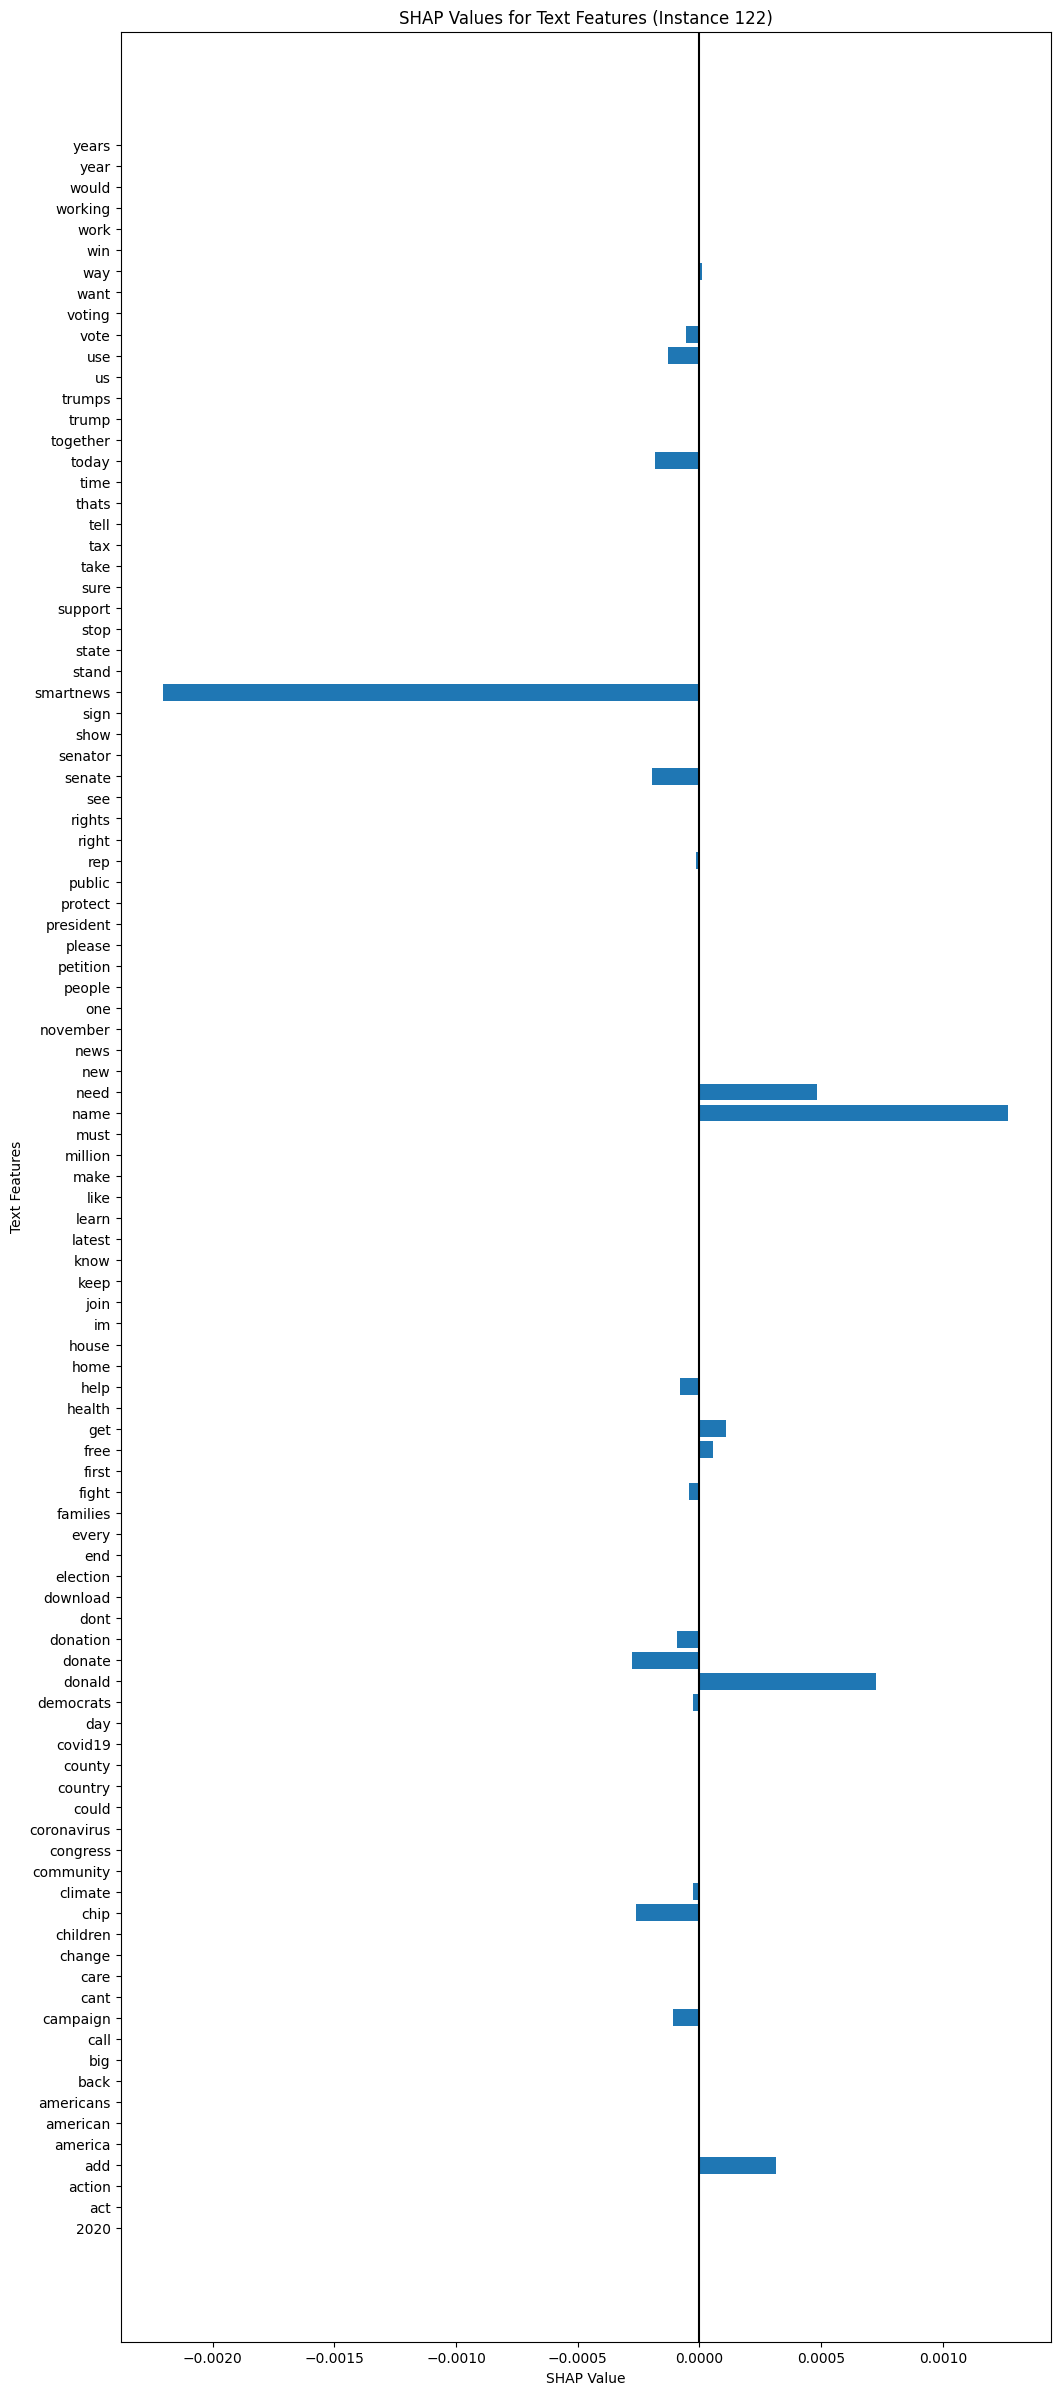

In [166]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# Select a single instance from the test set
instance_index = 122  # Adjust this index as needed
single_instance = X_test.iloc[instance_index:instance_index+1]

# Preprocess the single instance
single_instance_transformed = preprocessor.transform(single_instance)

# Convert to dense array if necessary
single_instance_dense = single_instance_transformed.toarray().astype(np.float64) if not isinstance(single_instance_transformed, np.ndarray) else single_instance_transformed.astype(np.float64)

# Create an explainer using the trained model
explainer = shap.Explainer(model.named_steps['model'], X_train_dense)

# Calculate SHAP values for the single instance
shap_values_single = explainer.shap_values(single_instance_dense)

# Extract the SHAP values for the instance
shap_values_instance = shap_values_single[0] if isinstance(shap_values_single, list) else shap_values_single

# Focus only on text features
text_shap_values_instance = shap_values_instance[:, :len(feature_names_text)]

# Get the feature names from the 'text' transformer
feature_names_text = preprocessor.named_transformers_['text'].get_feature_names_out()

# Adjusting the figure size for better readability
fig_height = len(feature_names_text) * 0.3  # 0.3 units per feature for spacing
plt.figure(figsize=(12, max(8, fig_height)))  # Ensure minimum size of 8

plt.barh(feature_names_text, text_shap_values_instance[0])
plt.xlabel('SHAP Value')
plt.ylabel('Text Features')
plt.title('SHAP Values for Text Features (Instance {})'.format(instance_index))
plt.axvline(x=0, color='k')
plt.show()


#EVALUATING THE MODEL

In [89]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Evaluate the model with CountVectorizer and other features
y_pred_full = model.predict(X_test_full)
mse_full = mean_squared_error(y_test_full, y_pred_full)
r2_full = r2_score(y_test_full, y_pred_full)
mae_full = mean_absolute_error(y_test_full, y_pred_full)

print("Evaluation for model with CountVectorizer and other features:")
print(f"Mean Squared Error: {mse_full:.2f}")
print(f"R-squared: {r2_full:.2f}")
print(f"Mean Absolute Error: {mae_full:.2f}")

# Evaluate the model with TF-IDF
y_pred_tfidf = gb_regressor_tfidf.predict(X_test_tfidf)
mse_tfidf = mean_squared_error(y_test, y_pred_tfidf)
r2_tfidf = r2_score(y_test, y_pred_tfidf)
mae_tfidf = mean_absolute_error(y_test, y_pred_tfidf)

print("\nEvaluation for model with TF-IDF:")
print(f"Mean Squared Error: {mse_tfidf:.2f}")
print(f"R-squared: {r2_tfidf:.2f}")
print(f"Mean Absolute Error: {mae_tfidf:.2f}")


Evaluation for model with CountVectorizer and other features:
Mean Squared Error: 0.08
R-squared: 0.00
Mean Absolute Error: 0.03

Evaluation for model with TF-IDF:
Mean Squared Error: 0.08
R-squared: 0.00
Mean Absolute Error: 0.04


In [ ]:
import matplotlib.pyplot as plt
import shap
import numpy as np
import pandas as pd
import re

def analyze_and_recommend(text, gender_age_percentages=None, feature_names_text=None, shap_values=None, explainer=None, preprocessor=None):
    # Preprocess the text
    processed_text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower()).split()

    # Create a DataFrame for prediction
    data_for_prediction = {'ad_creative_bodies': [' '.join(processed_text)]}

    # If gender and age group percentages are given, add them to the DataFrame
    if gender_age_percentages:
        for gender_age, percentage in gender_age_percentages.items():
            data_for_prediction[f'percentage_{gender_age}'] = [percentage]
    else:
        # If none given, assume equal impact for every category
        for gender_age in feature_names_text:
            if gender_age.startswith('percentage_'):
                data_for_prediction[gender_age] = [1.0 / len(feature_names_text)]

    # Transform the data
    transformed_data = preprocessor.transform(pd.DataFrame(data_for_prediction))

    # Convert to dense array if necessary
    if not isinstance(transformed_data, np.ndarray):
        transformed_data = transformed_data.toarray()

    # Ensure data type is float64 for SHAP calculations
    transformed_data = transformed_data.astype(np.float64)

    # Get SHAP values for the specific row
    shap_values_row = explainer.shap_values(transformed_data)[0]

    # Analyze and rank text features based on SHAP values
    text_shap_values = shap_values_row[:len(feature_names_text)]
    sorted_text_features = sorted(zip(feature_names_text, text_shap_values), key=lambda x: x[1], reverse=True)

    # Print Text Feature Recommendations
    print("\nText Feature Recommendations:")
    print("Positive Impact Words:")
    for feature, value in sorted_text_features:
        if value > 0:
            print(f"'{feature}': {value:.3f}")

    print("\nNegative Impact Words:")
    for feature, value in sorted_text_features:
        if value < 0:
            print(f"'{feature}': {value:.3f}")

    # Analyze gender-related SHAP values
    gender_age_suggestions = []
    for gender_age in feature_names_text:
        if gender_age.startswith('percentage_'):
            index = feature_names_text.index(gender_age)
            shap_value = shap_values_row[index]
            gender_age_suggestions.append((gender_age, shap_value))

    # Gender and Age Group Targeting Suggestions
    print("\nGender and Age Group Targeting Suggestions:")
    for gender_age, shap_value in gender_age_suggestions:
        if shap_value > 0:
            print(f"This text may be more successful with the {gender_age} audience.")
        elif shap_value < 0:
            print(f"This text may be less successful with the {gender_age} audience.")
        else:
            print(f"This text has a neutral impact on the {gender_age} audience.")

    return sorted_text_features, gender_age_suggestions


In [162]:
import pandas as pd
import numpy as np
column_names = [
        'ad_creative_bodies',
        'percentage_25-34_male',
        'percentage_25-34_female',
        'percentage_35-44_male',
        'percentage_13-17_male',
        'percentage_55-64_male',
        'percentage_18-24_male',
        'percentage_65+_male',
        'percentage_35-44_female',
        'percentage_13-17_female',
        'percentage_55-64_female',
        'percentage_18-24_female',
        'percentage_65+_female',
        'percentage_45-54_male',
        'percentage_45-54_female'
    ]

def create_null_data_array(text):
    # Define column names

    # Create an array with null values
    data_array = np.array([
        [text] + [None] * 14
    ], dtype=object)

    return data_array

import pandas as pd
import numpy as np

# Assuming you have a DataFrame named instance_template
# with the specified columns
columns = [
    'percentage_25-34_male', 'percentage_25-34_female',
    'percentage_35-44_male', 'percentage_13-17_male',
    'percentage_55-64_male', 'percentage_18-24_male',
    'percentage_65+_male', 'percentage_35-44_female',
    'percentage_13-17_female', 'percentage_55-64_female',
    'percentage_18-24_female', 'percentage_65+_female',
    'percentage_45-54_male', 'percentage_45-54_female'
]
import pandas as pd
import numpy as np

# Values for the DataFrame
values = [
    "sale male def saleman male saol no thank you donate me",
    0.0714285714285714, 0.0714285714285714, 0.0714285714285714,
    0.0714285714285714, 0.0714285714285714, 0.0714285714285714,
    0.0714285714285714, 0.0714285714285714, 0.0714285714285714,
    0.0714285714285714, 0.0714285714285714, 0.0714285714285714,
    0.0714285714285714, 0.0714285714285714
]

# Reshape the values into a 2D array with one row
data = np.array(values).reshape(1, -1)

# Create a DataFrame
columns = [
    'ad_creative_bodies',
    'percentage_25-34_male', 'percentage_25-34_female',
    'percentage_35-44_male', 'percentage_13-17_male',
    'percentage_55-64_male', 'percentage_18-24_male',
    'percentage_65+_male', 'percentage_35-44_female',
    'percentage_13-17_female', 'percentage_55-64_female',
    'percentage_18-24_female', 'percentage_65+_female',
    'percentage_45-54_male', 'percentage_45-54_female'
]

instance_template = pd.DataFrame(data, columns=columns)

# Display the DataFrame
print(instance_template)


                                  ad_creative_bodies percentage_25-34_male  \
0  sale male def saleman male saol no thank you d...    0.0714285714285714   

  percentage_25-34_female percentage_35-44_male percentage_13-17_male  \
0      0.0714285714285714    0.0714285714285714    0.0714285714285714   

  percentage_55-64_male percentage_18-24_male percentage_65+_male  \
0    0.0714285714285714    0.0714285714285714  0.0714285714285714   

  percentage_35-44_female percentage_13-17_female percentage_55-64_female  \
0      0.0714285714285714      0.0714285714285714      0.0714285714285714   

  percentage_18-24_female percentage_65+_female percentage_45-54_male  \
0      0.0714285714285714    0.0714285714285714    0.0714285714285714   

  percentage_45-54_female  
0      0.0714285714285714  


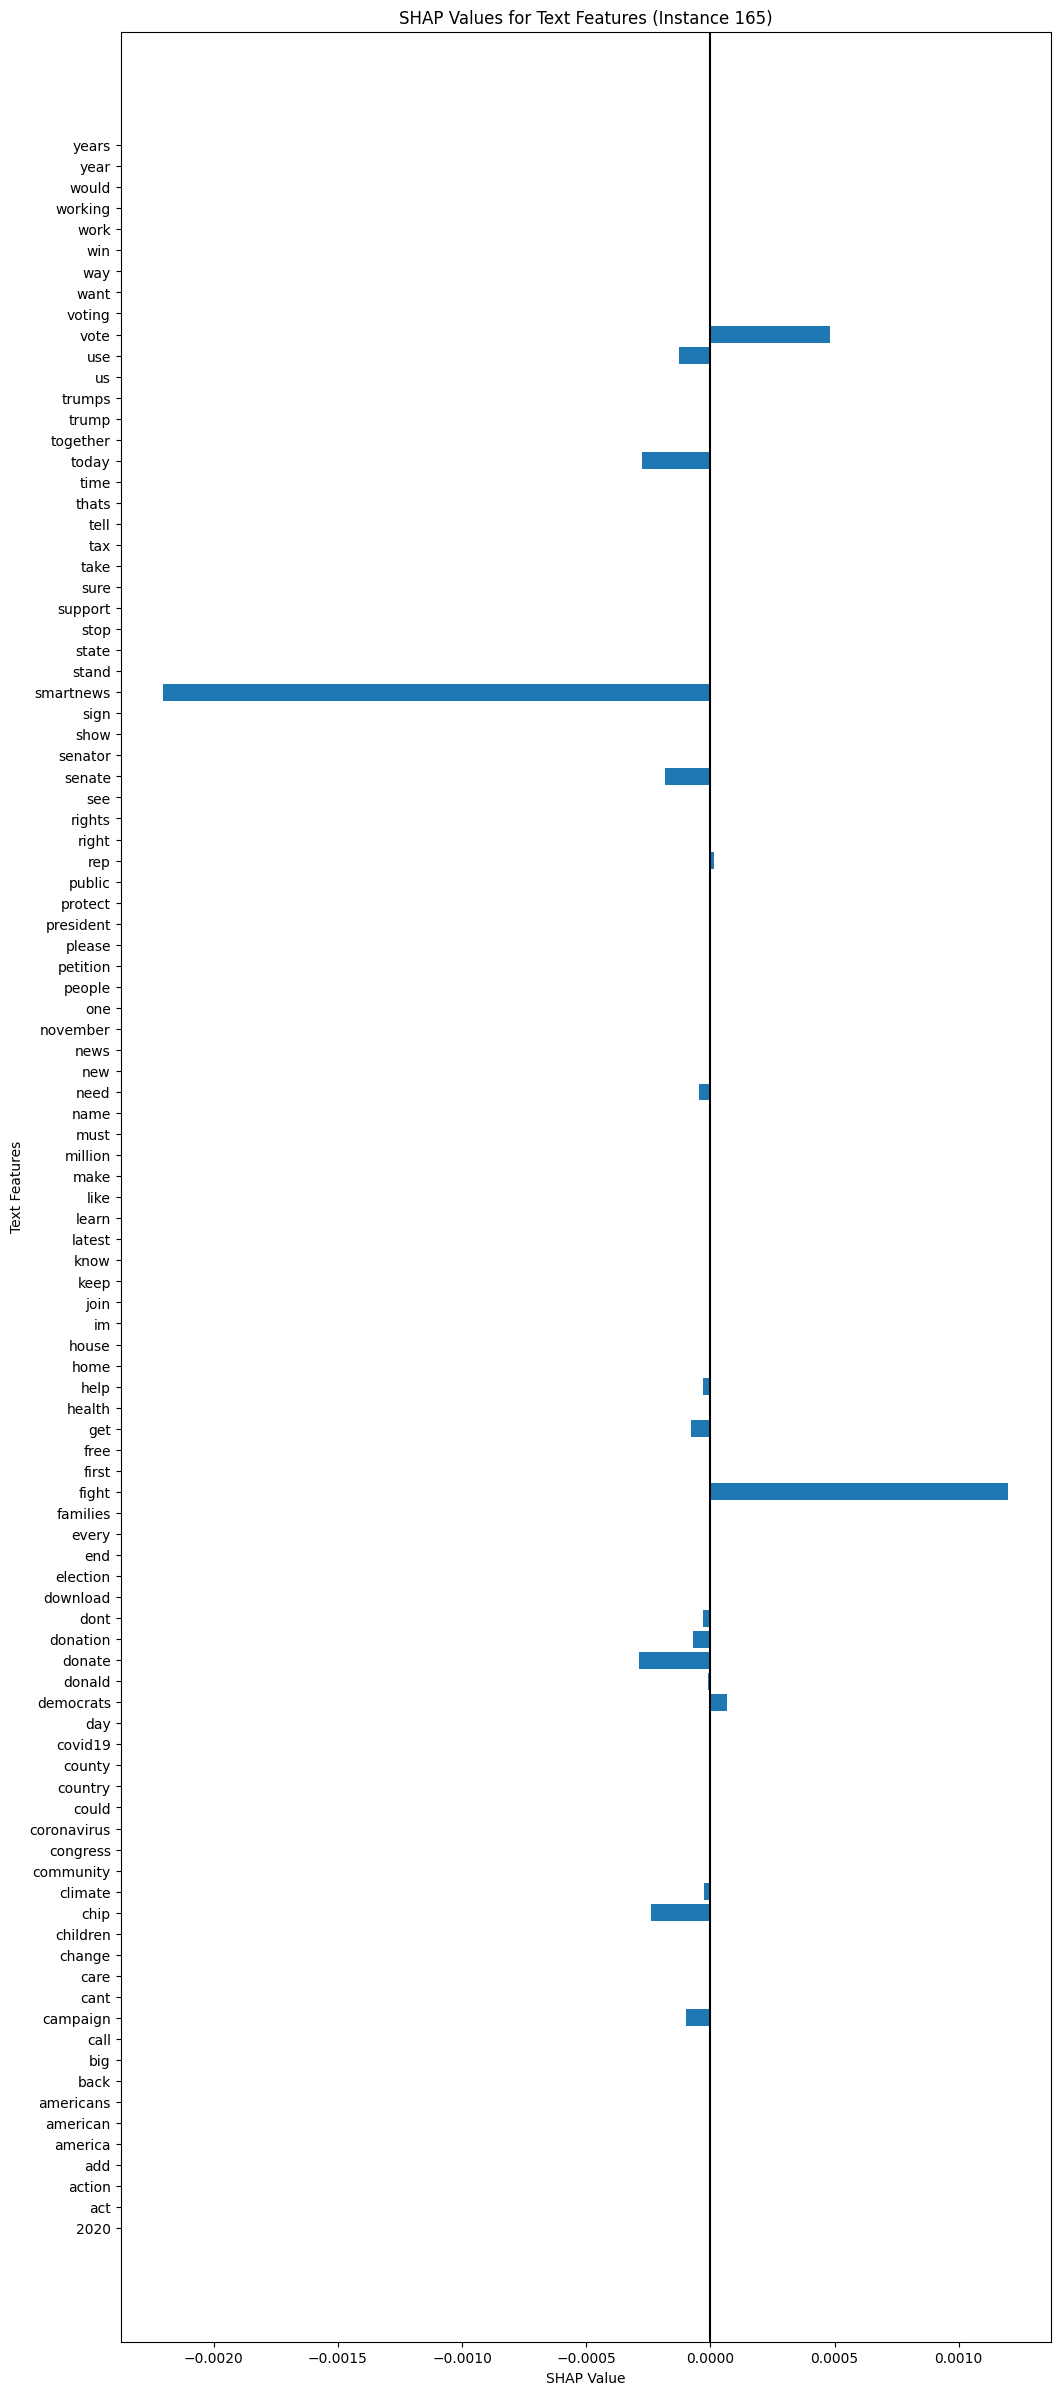

In [163]:
# Preprocess the single instance
single_instance_transformed = preprocessor.transform(instance_templete)

# Convert to dense array if necessary
single_instance_dense = single_instance_transformed.toarray().astype(np.float64) if not isinstance(single_instance_transformed, np.ndarray) else single_instance_transformed.astype(np.float64)

# Create an explainer using the trained model
explainer = shap.Explainer(model.named_steps['model'], X_train_dense)

# Calculate SHAP values for the single instance
shap_values_single = explainer.shap_values(single_instance_dense)

# Extract the SHAP values for the instance
shap_values_instance = shap_values_single[0] if isinstance(shap_values_single, list) else shap_values_single

# Focus only on text features
text_shap_values_instance = shap_values_instance[:, :len(feature_names_text)]

# Get the feature names from the 'text' transformer
feature_names_text = preprocessor.named_transformers_['text'].get_feature_names_out()

# Adjusting the figure size for better readability
fig_height = len(feature_names_text) * 0.3  # 0.3 units per feature for spacing
plt.figure(figsize=(12, max(8, fig_height)))  # Ensure minimum size of 8

plt.barh(feature_names_text, text_shap_values_instance[0])
plt.xlabel('SHAP Value')
plt.ylabel('Text Features')
plt.title('SHAP Values for Text Features (Instance {})'.format(instance_index))
plt.axvline(x=0, color='k')
plt.show()

                                  ad_creative_bodies percentage_25-34_male  \
0  sale male def saleman male saol no thank you d...    0.0714285714285714   

  percentage_25-34_female percentage_35-44_male percentage_13-17_male  \
0      0.0714285714285714    0.0714285714285714    0.0714285714285714   

  percentage_55-64_male percentage_18-24_male percentage_65+_male  \
0    0.0714285714285714    0.0714285714285714  0.0714285714285714   

  percentage_35-44_female percentage_13-17_female percentage_55-64_female  \
0      0.0714285714285714      0.0714285714285714      0.0714285714285714   

  percentage_18-24_female percentage_65+_female percentage_45-54_male  \
0      0.0714285714285714    0.0714285714285714    0.0714285714285714   

  percentage_45-54_female  
0      0.0714285714285714  


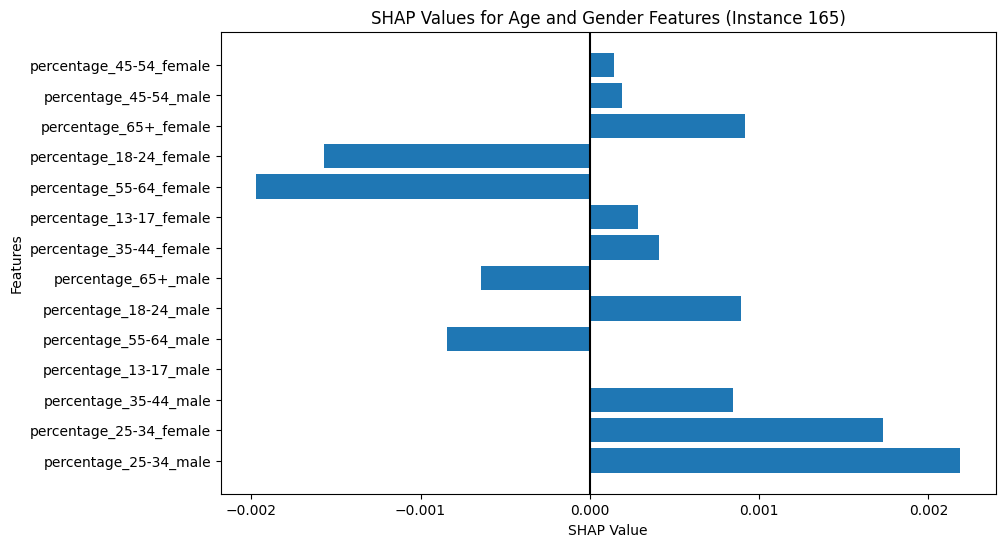

In [164]:
single_instance = data_df
print(instance_template)
# Preprocess the single instance
single_instance_transformed = preprocessor.transform(instance_templete)

# Convert to dense array if necessary
single_instance_dense = single_instance_transformed.toarray().astype(np.float64) if not isinstance(single_instance_transformed, np.ndarray) else single_instance_transformed.astype(np.float64)

# Create an explainer using the trained model
explainer = shap.Explainer(model.named_steps['model'], X_train_dense)

# Calculate SHAP values for the single instance
shap_values_single = explainer.shap_values(single_instance_dense)

# Extract the SHAP values for the instance
shap_values_instance = shap_values_single[0] if isinstance(shap_values_single, list) else shap_values_single

# Focus only on numeric features (age and gender)
numeric_shap_values_instance = shap_values_instance[:, len(feature_names_text):]

# Corresponding numeric feature names
numeric_feature_names = selected_percentage_columns

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(numeric_feature_names, numeric_shap_values_instance[0])
plt.xlabel('SHAP Value')
plt.ylabel('Features')
plt.title('SHAP Values for Age and Gender Features (Instance {})'.format(instance_index))
plt.axvline(x=0, color='k')
plt.show()
